In [0]:
import zipfile
f = zipfile.ZipFile("drive/My Drive/Colab Notebooks/train.zip")
f.extractall("./datasets")

In [0]:
import glob
import pandas as pd
catfs = glob.glob("datasets/train/cat.*.[jJ][pP][gG]")
catans = [0] * len(catfs)
dogfs = glob.glob("datasets/train/dog.*.[jJ][pP][gG]")
dogans = [1] * len(dogfs)
df = pd.DataFrame({
    "path":catfs + dogfs,
    "target":catans + dogans
})
df

,path,target
0,datasets/train/cat.11630.jpg,0
1,datasets/train/cat.3765.jpg,0
2,datasets/train/cat.591.jpg,0
3,datasets/train/cat.6686.jpg,0
4,datasets/train/cat.2384.jpg,0
...,...,...
24995,datasets/train/dog.9502.jpg,1
24996,datasets/train/dog.10694.jpg,1
24997,datasets/train/dog.7585.jpg,1
24998,datasets/train/dog.1878.jpg,1


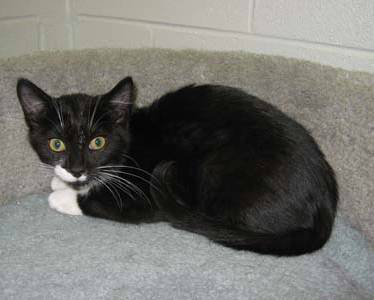

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img
idx = 1
load_img(df["path"][idx])

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
cnn.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

for l in cnn.layers:
    # !!! trainable一定要先設置
    l.trainable = False
# 放在flatten後完全不對
x = BatchNormalization()(cnn.output)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs=cnn.input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [0]:
#訓練以前，把所有的list, series... > nparray
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(df["target"]),
                                                    test_size=0.1)

In [0]:
# 請使用裡面的預處理(不要自己來)
from tensorflow.keras.applications.vgg16 import preprocess_input
# return: (原圖(batch), 處理後圖(batch), 答案(batch))
def dataflow(x, y, batch=20):
    idx = np.random.randint(0, x.shape[0], size=batch)
    x_batch, y_batch = x[idx], y[idx]
    x_ori, x_pre = [], []
    for fp in x_batch:
        img = load_img(fp, target_size=(224, 224))
        img_np = np.array(img)
        # 原本的圖片我存一份
        x_ori.append(img_np)
        img_pre = preprocess_input(img_np)
        # 預處理的圖片
        x_pre.append(img_pre)
    x_ori, x_pre = np.array(x_ori), np.array(x_pre)
    return (x_ori, x_pre, y_batch)

In [0]:
for i in range(20):
    print("-" * 10, i, "-" * 10)
    _, x, y = dataflow(x_train, y_train)
    result = model.train_on_batch(x, y)
    print("[Train]:", result)
    # 如果有時間的話, validate batch可以調高一點
    _, x, y = dataflow(x_test, y_test)
    result = model.test_on_batch(x, y)
    print("[Validate]:", result)

---------- 0 ----------
[Train]: [0.7110644578933716, 0.699999988079071]
[Validate]: [2.1667320728302, 0.75]
---------- 1 ----------
[Train]: [0.869604229927063, 0.800000011920929]
[Validate]: [1.7990328073501587, 0.8999999761581421]
---------- 2 ----------
[Train]: [0.3080172538757324, 0.8500000238418579]
[Validate]: [5.286166191101074, 0.6499999761581421]
---------- 3 ----------
[Train]: [0.7241426706314087, 0.699999988079071]
[Validate]: [4.2097063064575195, 0.8500000238418579]
---------- 4 ----------
[Train]: [0.6550713777542114, 0.8500000238418579]
[Validate]: [14.71130084991455, 0.6000000238418579]
---------- 5 ----------
[Train]: [0.5261931419372559, 0.8500000238418579]
[Validate]: [8.095136642456055, 0.699999988079071]
---------- 6 ----------
[Train]: [0.35640668869018555, 0.8500000238418579]
[Validate]: [0.00405151816084981, 1.0]
---------- 7 ----------
[Train]: [0.9227128028869629, 0.8500000238418579]
[Validate]: [3.0552730560302734, 0.8999999761581421]
---------- 8 ---------

In [0]:
model.predict(x)

array([[1.5774534e-35, 1.0000000e+00],
       [7.8868531e-22, 1.0000000e+00],
       [1.0000000e+00, 6.9826591e-19],
       [1.0000000e+00, 7.0028964e-14],
       [5.2810304e-12, 1.0000000e+00],
       [1.0000000e+00, 5.1973986e-24],
       [1.0000000e+00, 0.0000000e+00],
       [9.7557402e-01, 2.4425965e-02],
       [8.5646889e-15, 1.0000000e+00],
       [1.0000000e+00, 1.8343370e-35],
       [9.0934672e-14, 1.0000000e+00],
       [1.0000000e+00, 1.3432266e-11],
       [7.1143793e-34, 1.0000000e+00],
       [2.8760544e-15, 1.0000000e+00],
       [4.0703335e-37, 1.0000000e+00],
       [1.0000000e+00, 5.0252401e-19],
       [1.0000000e+00, 9.4709585e-22],
       [1.0000000e+00, 1.9749916e-24],
       [9.9998951e-01, 1.0516055e-05],
       [1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [0]:
timg, tx, ty = dataflow(x_test, y_test, 500)
model.evaluate(tx, ty)

16/16 [==============================] - 1s 62ms/step - loss: 2.8813 - accuracy: 0.8780


[2.88131046295166, 0.878000020980835]

In [0]:
# predict_classes: Model沒有
# predict + argmax = predict_classes
# argmax: 幫你找到最小值的index(axis=-1 == axis=1)
pre = model.predict(tx).argmax(axis=-1)
pre

array([0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,

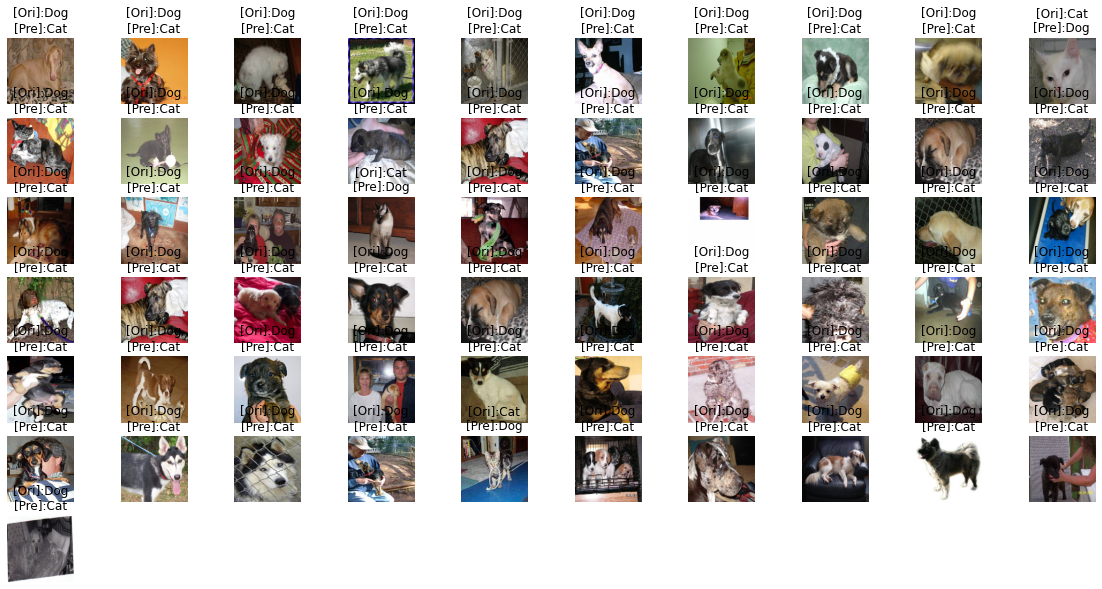

In [0]:
# nonzero: 取出是True的index
# (x座標, y座標, z座標)
trans = ["Cat", "Dog"]
idx = np.nonzero(pre != ty)[0]
# 預測錯誤的圖
false_img = timg[idx]
false_answer = ty[idx]
false_predict = pre[idx]

# 把圖變大一點才塞的下
plt.figure(figsize=(20, 10))
width = 10
height = len(false_img) // width + 1
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    plt.axis("off")
    t = "[Ori]:{}\n[Pre]:{}".format(trans[false_answer[i]],
                                    trans[false_predict[i]])
    plt.title(t)
    plt.imshow(img)